# Making predictions on the `test_dataset`

This notebook demonstrates how a fine-tuned CNN can be evaluated using randomly selected validation splits. Here, we'll demonstrate using a trained and fine-tuned CNN to make predictions on an independent test set.

Copyright (C) 2023, Zhao Bingqiang, All Rights Reserved

Email: zbqherb@163.com

2023-07-02

# Import Libs

In [24]:
import os
import math
import cv2
import itertools
import random

import numpy as np
import pandas as pd
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from PIL import Image

import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## `test_dataset`  prediction results

### `test_dataset` image preprocessing

In [25]:
# COVID-19 CT
train_transform = transforms.Compose([transforms.RandomResizedCrop(512),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))])

test_transform = transforms.Compose([transforms.Resize(1000),
                                     transforms.CenterCrop(512),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

### Load `trained model` and `test_dataset`

Now we load weights that we previously trained using the `ImageNet` and fine-tuned using the `train_dataset`. We will use this trained model to make predictions on the `test_dataset`.

In [26]:
model = torch.load('checkpoint/best-0.971.pth')
model = model.eval().to(device)
idx_to_labels = np.load('table/idx_to_labels.npy', allow_pickle = True).item()
classes = list(idx_to_labels.values())

dataset_dir = 'data_split'
test_path = os.path.join(dataset_dir, 'val')
test_dataset = datasets.ImageFolder(test_path, test_transform)
print('test_dataset number', len(test_dataset))
print('test_dataset class number', len(test_dataset.classes))
print('test_dataset class name', test_dataset.classes)

test_dataset number 3419
test_dataset class number 3
test_dataset class name ['CAP', 'COVID', 'NonCOVID']


### Table A - test_dataset image path and annotation

In [27]:
img_paths = [each[0] for each in test_dataset.imgs]
df = pd.DataFrame()
df['Data Path'] = img_paths
df['Label ID'] = test_dataset.targets
df['Label Name'] = [idx_to_labels[ID] for ID in test_dataset.targets]

df

,Data Path,Label ID,Label Name
0,data_split\val\CAP\cap006_12.png,0,CAP
1,data_split\val\CAP\cap006_20.png,0,CAP
2,data_split\val\CAP\cap006_23.png,0,CAP
3,data_split\val\CAP\cap006_27.png,0,CAP
4,data_split\val\CAP\cap006_7.png,0,CAP
...,...,...,...
3414,data_split\val\NonCOVID\normal036_139.png,2,NonCOVID
3415,data_split\val\NonCOVID\normal036_147.png,2,NonCOVID
3416,data_split\val\NonCOVID\normal038_174.png,2,NonCOVID
3417,data_split\val\NonCOVID\normal038_177.png,2,NonCOVID


### Table B - Prediction result of each image in `test_dataset` and their confidence

In [28]:
# top-n Prediction result
n = 3

df_pred = pd.DataFrame()

for idx, row in tqdm(df.iterrows()):
    img_path = row['Data Path']
    img_pil = Image.open(img_path).convert('RGB')
    input_img = test_transform(img_pil).unsqueeze(0).to(device) # Preprocess
    pred_logits = model(input_img) # feed-forward prediction
    pred_softmax = F.softmax(pred_logits, dim=1) # softmax on logit score
    pred_dict = {}

    top_n = torch.topk(pred_softmax, n) #  n highest confidence level
    pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 
    
    # top-n Prediction results
    for i in range(1, n+1):
        pred_dict['top-{} Predicted ID'.format(i)] = pred_ids[i-1]
        pred_dict['top-{} Predicted Name'.format(i)] = idx_to_labels[pred_ids[i-1]]
    pred_dict['top-n Predicted True'] = row['Label ID'] in pred_ids
    
    # Prediction confidence for each class
    for idx, each in enumerate(classes):
        pred_dict['{} Predicted Confidence'.format(each)] = pred_softmax[0][idx].cpu().detach().numpy()
        
    df_pred = df_pred._append(pred_dict, ignore_index = True)
    
df_pred

3419it [02:05, 27.19it/s]


,top-1 Predicted ID,top-1 Predicted Name,top-2 Predicted ID,top-2 Predicted Name,top-3 Predicted ID,top-3 Predicted Name,top-n Predicted True,CAP Predicted Confidence,COVID Predicted Confidence,NonCOVID Predicted Confidence
0,0,CAP,1,COVID,2,NonCOVID,True,0.9999987,1.2939795e-06,7.600389e-10
1,0,CAP,1,COVID,2,NonCOVID,True,0.9998771,0.00012285005,3.7657017e-08
2,0,CAP,1,COVID,2,NonCOVID,True,0.9998147,0.00018530311,1.903462e-08
3,0,CAP,1,COVID,2,NonCOVID,True,0.9121713,0.087755784,7.301371e-05
4,0,CAP,1,COVID,2,NonCOVID,True,0.99999666,3.3375238e-06,4.421886e-09
...,...,...,...,...,...,...,...,...,...,...
3414,2,NonCOVID,1,COVID,0,CAP,True,0.0006487101,0.009386657,0.98996466
3415,2,NonCOVID,1,COVID,0,CAP,True,0.0033800518,0.006124728,0.9904952
3416,2,NonCOVID,1,COVID,0,CAP,True,1.0213349e-05,0.1301089,0.8698809
3417,2,NonCOVID,1,COVID,0,CAP,True,8.59841e-06,0.23111969,0.7688717


### Concatenate `Table A` and `Table B`

In [29]:
df = pd.concat([df, df_pred], axis = 1)
df.to_csv('table/test_dataset prediction results.csv', index = False)

df

,Data Path,Label ID,Label Name,top-1 Predicted ID,top-1 Predicted Name,top-2 Predicted ID,top-2 Predicted Name,top-3 Predicted ID,top-3 Predicted Name,top-n Predicted True,CAP Predicted Confidence,COVID Predicted Confidence,NonCOVID Predicted Confidence
0,data_split\val\CAP\cap006_12.png,0,CAP,0,CAP,1,COVID,2,NonCOVID,True,0.9999987,1.2939795e-06,7.600389e-10
1,data_split\val\CAP\cap006_20.png,0,CAP,0,CAP,1,COVID,2,NonCOVID,True,0.9998771,0.00012285005,3.7657017e-08
2,data_split\val\CAP\cap006_23.png,0,CAP,0,CAP,1,COVID,2,NonCOVID,True,0.9998147,0.00018530311,1.903462e-08
3,data_split\val\CAP\cap006_27.png,0,CAP,0,CAP,1,COVID,2,NonCOVID,True,0.9121713,0.087755784,7.301371e-05
4,data_split\val\CAP\cap006_7.png,0,CAP,0,CAP,1,COVID,2,NonCOVID,True,0.99999666,3.3375238e-06,4.421886e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3414,data_split\val\NonCOVID\normal036_139.png,2,NonCOVID,2,NonCOVID,1,COVID,0,CAP,True,0.0006487101,0.009386657,0.98996466
3415,data_split\val\NonCOVID\normal036_147.png,2,NonCOVID,2,NonCOVID,1,COVID,0,CAP,True,0.0033800518,0.006124728,0.9904952
3416,data_split\val\NonCOVID\normal038_174.png,2,NonCOVID,2,NonCOVID,1,COVID,0,CAP,True,1.0213349e-05,0.1301089,0.8698809
3417,data_split\val\NonCOVID\normal038_177.png,2,NonCOVID,2,NonCOVID,1,COVID,0,CAP,True,8.59841e-06,0.23111969,0.7688717


# `test_dataset` overal performance

## Load `idx_to_labels.npy`, `test_dataset prediction results.csv`

In [30]:
df = pd.read_csv('table/test_dataset prediction results.csv')

# Accuracy
sum(df['Label Name'] == df['top-1 Predicted Name']) / len(df)
# top-n Accuracy
sum(df['top-n Predicted True']) / len(df)
# Other Metrics
print(classification_report(df['Label Name'], df['top-1 Predicted Name'], target_names=classes))

              precision    recall  f1-score   support

         CAP       0.98      0.99      0.98       523
       COVID       0.98      0.96      0.97      1518
    NonCOVID       0.96      0.98      0.97      1378

    accuracy                           0.97      3419
   macro avg       0.97      0.98      0.97      3419
weighted avg       0.97      0.97      0.97      3419



In [31]:
report = classification_report(df['Label Name'], df['top-1 Predicted Name'], target_names=classes, output_dict=True)
del report['accuracy']

df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
CAP,0.981025,0.988528,0.984762,523.0
COVID,0.977852,0.959816,0.968750,1518.0
NonCOVID,0.960770,0.977504,0.969065,1378.0
macro avg,0.973216,0.975282,0.974192,3419.0
weighted avg,0.971453,0.971337,0.971326,3419.0


## all classes accuracy（recall）

In [32]:
accuracy_list = []
for image in tqdm(classes):
    df_temp = df[df['Label Name'] == image]
    accuracy = sum(df_temp['Label Name'] == df_temp['top-1 Predicted Name']) / len(df_temp)
    accuracy_list.append(accuracy)
    
# macro avg accuracy and weighted avg accuracy
acc_macro = np.mean(accuracy_list)
acc_weighted = sum(accuracy_list * df_report.iloc[:-2]['support'] / len(df))

accuracy_list.append(acc_macro)
accuracy_list.append(acc_weighted)

df_report['accuracy'] = accuracy_list
df_report.to_csv('table/all classes accuracy.csv', index_label = 'Label')

df_report

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.65it/s]


,precision,recall,f1-score,support,accuracy
CAP,0.981025,0.988528,0.984762,523.0,0.988528
COVID,0.977852,0.959816,0.968750,1518.0,0.959816
NonCOVID,0.960770,0.977504,0.969065,1378.0,0.977504
macro avg,0.973216,0.975282,0.974192,3419.0,0.975282
weighted avg,0.971453,0.971337,0.971326,3419.0,0.971337


# Confusion Matrix

We use the predictions to plot a version of the confusion matrix. Each row represents the true class and each columen represents the predicted class. The accuracy for each class can be seen in the diagonal entries.

In [33]:
confusion_matrix_model = confusion_matrix(df['Label Name'], df['top-1 Predicted Name'])
confusion_matrix_model

array([[ 517,    5,    1],
       [   7, 1457,   54],
       [   3,   28, 1347]], dtype=int64)

## Visualize Confusion Matrix

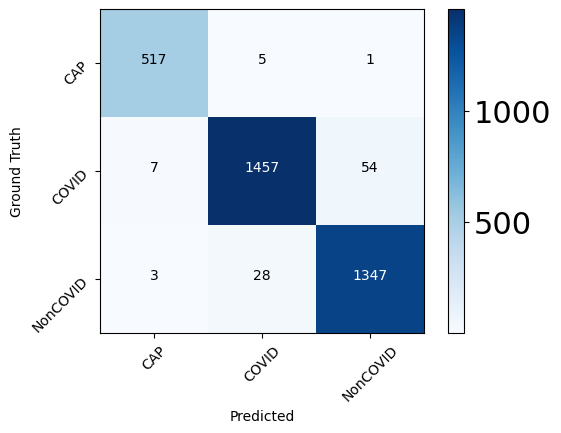

In [34]:
def CM_plotter(cm, classes, cmap = plt.cm.Blues):
   
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap, aspect = 'equal') 
    tick_marks = np.arange(len(classes))
    
    plt.xlabel('Predicted', fontsize = 10, c = 'k')
    plt.ylabel('Ground Truth', fontsize = 10, c = 'k')
    plt.tick_params(labelsize = 10) 
    plt.xticks(tick_marks, classes, rotation = 45) 
    plt.yticks(tick_marks, classes, rotation = 45)
    plt.colorbar()
    
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > threshold else "black",
                 fontsize = 10)
    plt.tight_layout()

    plt.savefig('figure/Confusion Matrix.tif', dpi = 300, bbox_inches = 'tight') 
    plt.show()
    
CM_plotter(confusion_matrix_model, classes, cmap = 'Blues') # RdPu

# PR curves

## PR curves for a class

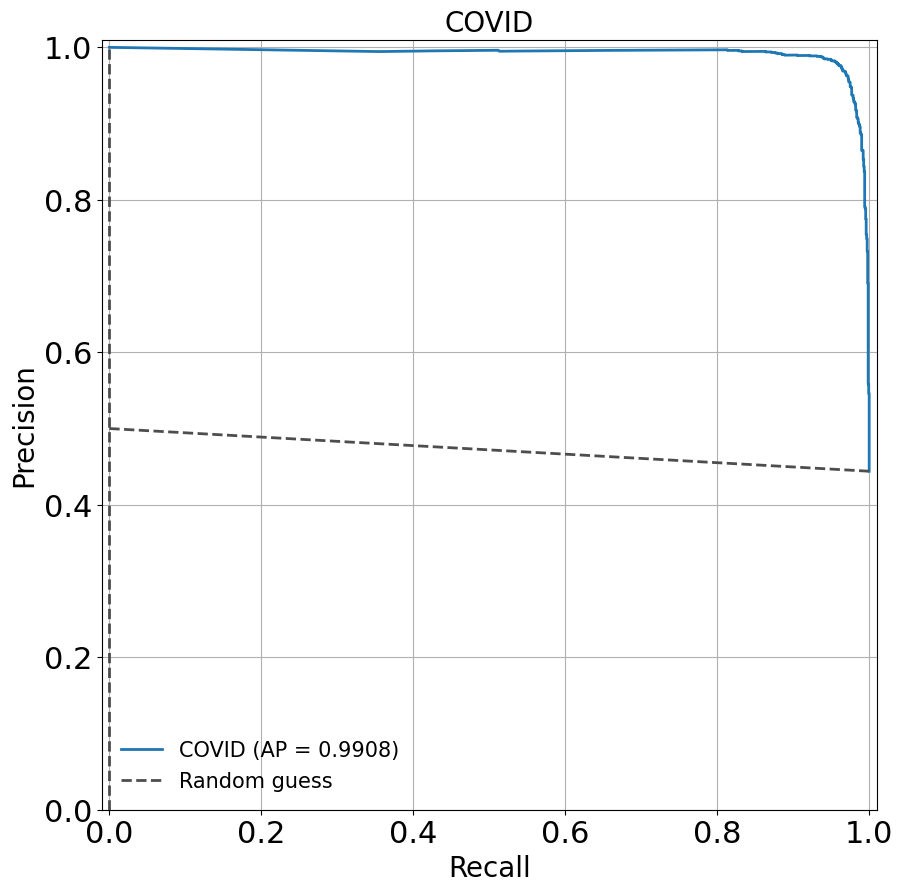

In [35]:
specific_class = 'COVID'

# Binary classification labeling
y_test = (df['Label Name'] == specific_class)
# Binary classification prediction confidence
y_score = df['COVID Predicted Confidence']

precision, recall, thresholds = precision_recall_curve(y_test, y_score)
AP = average_precision_score(y_test, y_score, average='weighted')

label = 'COVID (AP = %0.4f)' % AP


plt.figure(figsize = (10, 10))
plt.plot(recall, precision, linewidth = 2, label = label)


plt.plot([0, 0], [0, 1], ls = "--", c = '.3', linewidth = 2, label = 'Random guess')
plt.plot([0, 1], [0.5, sum(y_test == 1)/len(df)], ls = "--", c = '.3', linewidth = 2)

plt.xlim([-0.01, 1.01])
plt.ylim([0.0, 1.01])
plt.title('{}'.format(specific_class),fontsize = 20)
plt.xlabel('Recall', fontsize = 20, c = 'k')
plt.ylabel('Precision', fontsize = 20, c = 'k')
plt.grid(True)
plt.legend(loc = 3, fontsize = 15, frameon = False)
plt.savefig('figure/{}-PR Curve.tif'.format(specific_class), dpi = 300, bbox_inches = 'tight')

## PR curve for all classes

In [36]:
random.seed(124)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
linestyle = ['--', '-.', '-']

def get_line_arg():
    '''
    Randomly generate a drawing line type
    '''
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
#     line_arg['linewidth'] = random.randint(1, 4)
    line_arg['linewidth'] = 2
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

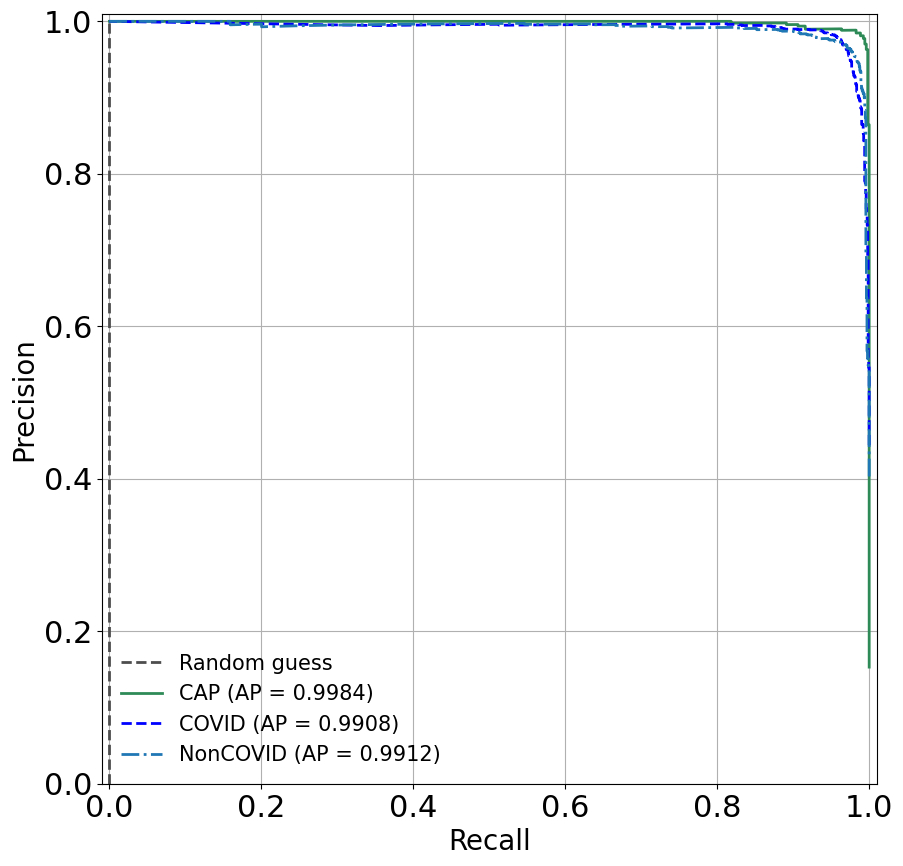

In [37]:
plt.figure(figsize = (10, 10))
plt.xlim([-0.01, 1.01])
plt.ylim([0.0, 1.01])
plt.plot([0, 0], [0, 1],ls = "--", c = '.3', linewidth = 2, label = 'Random guess')

plt.xlabel('Recall', fontsize = 20, c = 'k')
plt.ylabel('Precision', fontsize = 20, c = 'k')
plt.rcParams['font.size'] = 22
plt.grid(True)

ap_list = []
for each_class in classes:
    y_test = list((df['Label Name'] == each_class))
    y_score = list(df['{} Predicted Confidence'.format(each_class)])
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    AP = average_precision_score(y_test, y_score, average = 'weighted')
    
    label = '{} (AP = %0.4f)'.format(each_class) % AP
    
    plt.plot(recall, precision, **get_line_arg(), label = label)
    ap_list.append(AP)

plt.legend(loc = 3, fontsize = 15, frameon = False)
plt.savefig('figure/Total PR Curve.tif'.format(specific_class), dpi = 300, bbox_inches='tight')

## Add AP value to `all classes accuracy.csv`

In [38]:
df_report = pd.read_csv('table/all classes accuracy.csv')

macro_avg_auc = np.mean(ap_list)
weighted_avg_auc = sum(ap_list * df_report.iloc[:-2]['support'] / len(df))

ap_list.append(macro_avg_auc)
ap_list.append(weighted_avg_auc)

df_report['AP'] = ap_list
df_report.to_csv('table/all classes accuracy.csv', index = False)

df_report

,Label,precision,recall,f1-score,support,accuracy,AP
0,CAP,0.981025,0.988528,0.984762,523.0,0.988528,0.998420
1,COVID,0.977852,0.959816,0.968750,1518.0,0.959816,0.990752
2,NonCOVID,0.960770,0.977504,0.969065,1378.0,0.977504,0.991169
3,macro avg,0.973216,0.975282,0.974192,3419.0,0.975282,0.993447
4,weighted avg,0.971453,0.971337,0.971326,3419.0,0.971337,0.992093


# ROC curves

In [39]:
fpr, tpr, threshold = roc_curve(y_test, y_score)

## ROC curves for a class

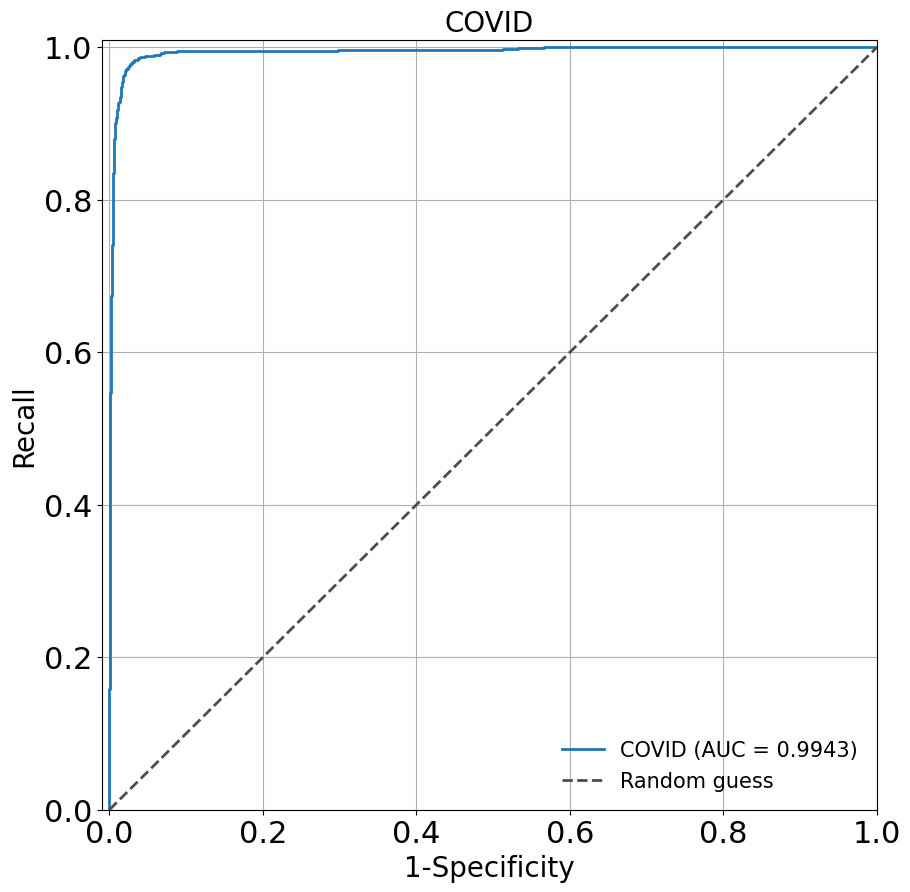

In [40]:
label = 'COVID (AUC = %0.4f)' % auc(fpr, tpr)

plt.figure(figsize = (10, 10))
plt.plot(fpr, tpr, linewidth = 2, label = label)
plt.plot([0, 1], [0, 1],ls = "--", c = '.3', linewidth = 2, label = 'Random guess')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.title('{}'.format(specific_class), fontsize = 20)
plt.xlabel('1-Specificity', fontsize = 20, c = 'k')
plt.ylabel('Recall', fontsize = 20, c = 'k')
plt.legend(loc = 4, fontsize = 15, frameon = False)
plt.grid(True)

plt.savefig('figure/{}-ROC Curve.tif'.format(specific_class), dpi = 300, bbox_inches = 'tight')

## ROC curve for all classes

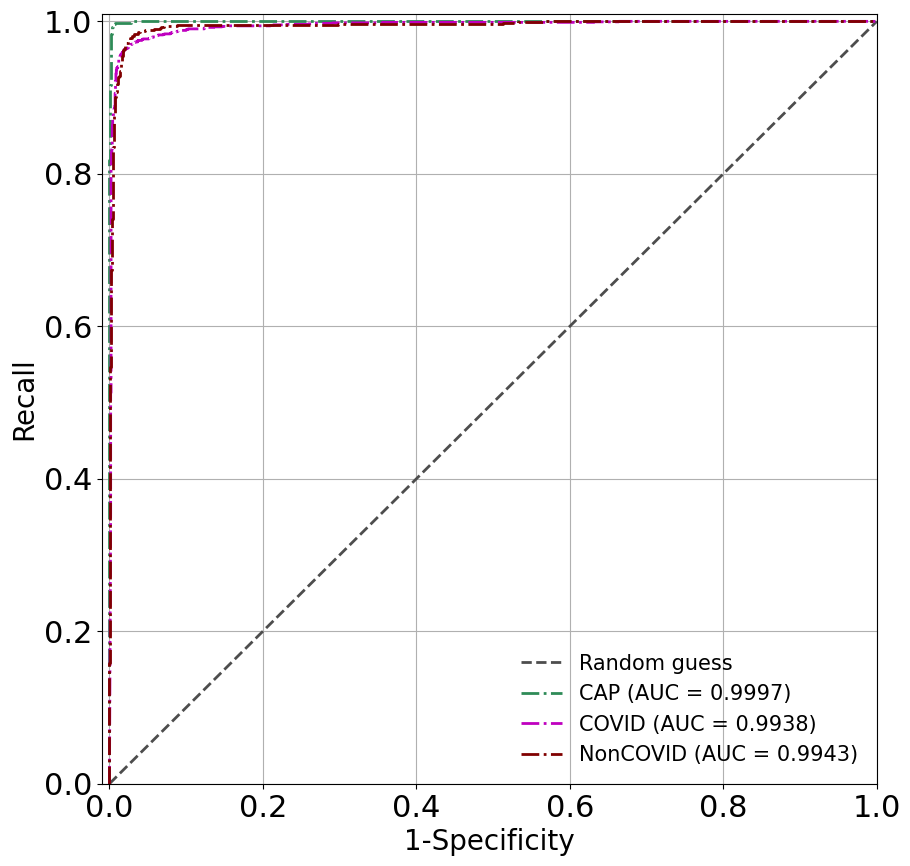

In [41]:
plt.figure(figsize = (10, 10))
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.plot([0, 1], [0, 1],ls = "--", c = '.3', linewidth = 2, label = 'Random guess')
plt.xlabel('1-Specificity', fontsize = 20, c = 'k')
plt.ylabel('Recall', fontsize = 20, c = 'k')
plt.rcParams['font.size'] = 22
plt.grid(True)

auc_list = []
for each_class in classes:
    y_test = list((df['Label Name'] == each_class))
    y_score = list(df['{} Predicted Confidence'.format(each_class)])
    fpr, tpr, threshold = roc_curve(y_test, y_score) 
    label = '{} (AUC = %0.4f)'.format(each_class) % auc(fpr, tpr)
    plt.plot(fpr, tpr, **get_line_arg(), label = label)
    auc_list.append(auc(fpr, tpr))

plt.legend(loc = 4, fontsize = 15, frameon = False)
plt.savefig('figure/all classes ROC curve.tif'.format(specific_class), dpi = 300, bbox_inches = 'tight')

## Add AUC value to `all classes accuracy.csv`

In [42]:
df_report = pd.read_csv('table/all classes accuracy.csv')

macro_avg_auc = np.mean(auc_list)
weighted_avg_auc = sum(auc_list * df_report.iloc[:-2]['support'] / len(df))

auc_list.append(macro_avg_auc)
auc_list.append(weighted_avg_auc)

df_report['AUC'] = auc_list

df_report.to_csv('table/all classes accuracy.csv', index = False)

df_report

,Label,precision,recall,f1-score,support,accuracy,AP,AUC
0,CAP,0.981025,0.988528,0.984762,523.0,0.988528,0.998420,0.999717
1,COVID,0.977852,0.959816,0.968750,1518.0,0.959816,0.990752,0.993808
2,NonCOVID,0.960770,0.977504,0.969065,1378.0,0.977504,0.991169,0.994263
3,macro avg,0.973216,0.975282,0.974192,3419.0,0.975282,0.993447,0.995929
4,weighted avg,0.971453,0.971337,0.971326,3419.0,0.971337,0.992093,0.994895


# Hist plot of each class accuracy

## Hist plot

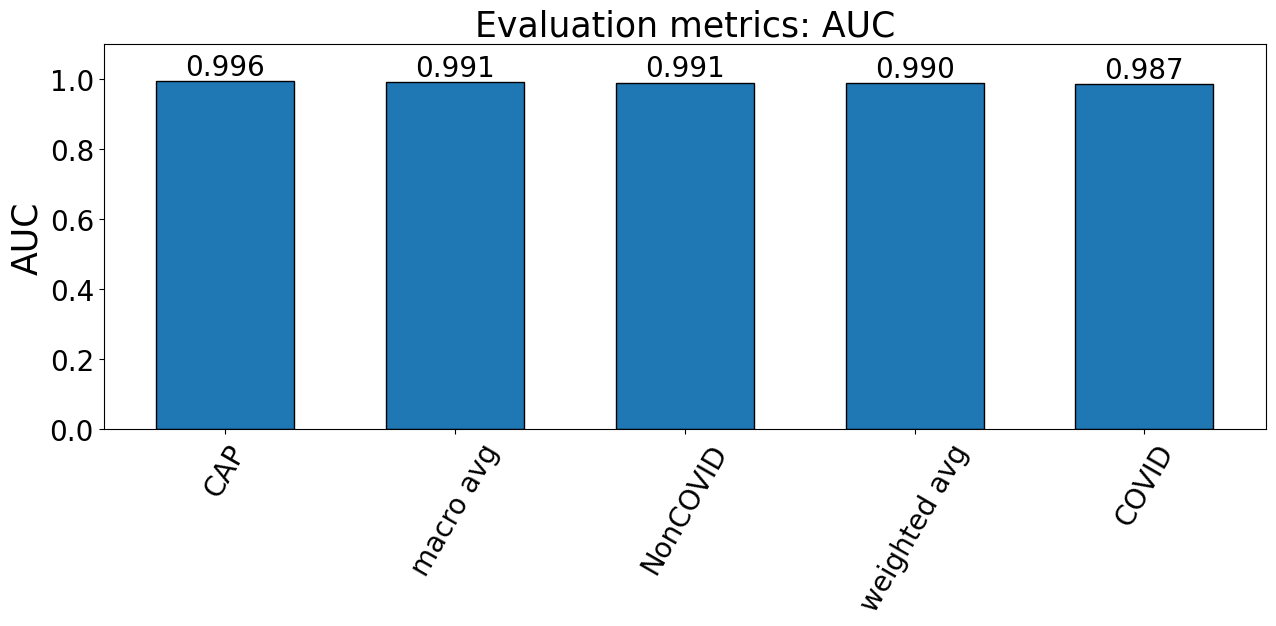

In [27]:
df = pd.read_csv('table/all classes accuracy.csv')

# Evaluation Index
# feature = 'precision'
# feature = 'f1-score'
# feature = 'accuracy'
# feature = 'AP'
feature = 'AUC'

df_plot = df.sort_values(by = feature, ascending = False)
plt.figure(figsize = (15, 5))
x = df_plot['Label']
y = df_plot[feature]
ax = plt.bar(x, y, width = 0.6, facecolor = '#1f77b4', edgecolor = 'k')
plt.bar_label(ax, fmt = '%.3f', fontsize = 20) # Confidence
plt.xticks(rotation = 60)
plt.tick_params(labelsize = 20)
plt.ylim(0, 1.1)
plt.ylabel(feature, fontsize = 25)
plt.title('Evaluation metrics: {}'.format(feature), fontsize=25)
plt.savefig('figure/all classes accuracy-{}.tif'.format(feature), dpi = 300, bbox_inches = 'tight')